In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint

In [6]:

'''An SE(A)IR model described the paper:
Bayesian particle filter algorithm for learning epidemic dynamics
Calvetti et. al. '''

'''The model dynamics are designed for COVID, with SEAIRD dynamics. Given the absence of additional time series information,
they combine the E and A compartments into a single compartment denoted E(A)'''


beta_par = {'beta_0':0.4,'beta_inf':0.1,'T':20,'tau':5} #hyperparameters for the functional form of beta

'''Functional beta'''
def beta(t,beta_par):

    if(t<beta_par['T']):
        return beta_par['beta_0']

    return beta_par['beta_inf'] + (beta_par['beta_0'] - beta_par['beta_inf']) * np.exp(-(t-beta_par['T'])/beta_par['tau'])


'''Model parameters'''
params = np.array([1/14,1/7])

def RHS(y,t,par,beta):
  gamma,eta = par
  S,E,I,R = y
  N = np.sum(y)
  dS = - beta(t) * ((E + 0.1 * I)/N) * S
  dE = beta(t) * ((E + 0.1 * I)/N) * S - eta*E - gamma*E
  dI = eta * E - gamma * I - 0.004 * I
  dR = gamma * E + gamma * I

  return np.array([dS,dE,dI,dR])
    

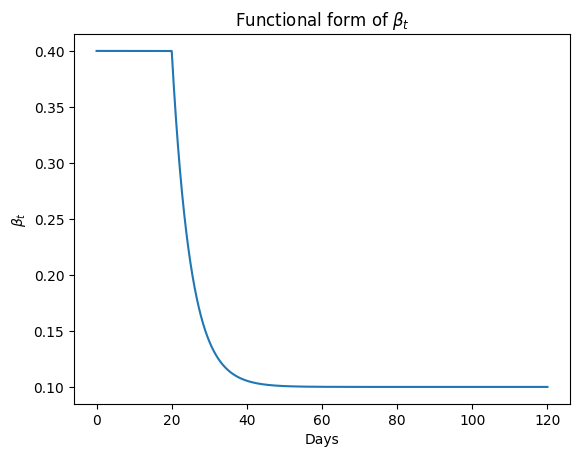

In [7]:
'''Plots the functional form of beta(t), negative exponential'''

beta_ts = np.linspace(0,120,120000)

betas = []
for i in range(np.shape(beta_ts)[0]):
    betas.append(beta(beta_ts[i],beta_par))

plt.xlabel('Days')
plt.ylabel('$\\beta_t$')
plt.title('Functional form of $\\beta_t$')
plt.plot(beta_ts,np.array(betas))

In [8]:
t_span = np.linspace(0,120,120)
initial_infected = 2
y0 = [100_000 - initial_infected-initial_infected,initial_infected,initial_infected,0]

'''
Solves the ODE system for Protocol A, gamma = 1/14, eta = 1/7
'''
sol = odeint(func=lambda y,t: RHS(y,t,params,lambda t: beta(t,beta_par)),t = t_span,y0 = y0)

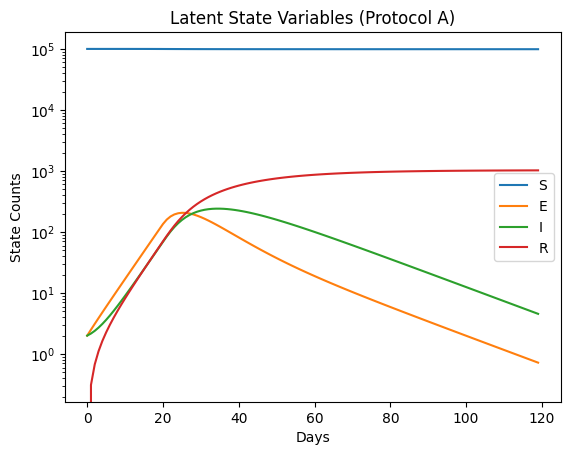

In [9]:
'''Plotting for the state variables'''

plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('State Counts')
plt.title('Latent State Variables (Protocol A)')
labels = ['S','E','I','R']
for i in range(4):
    plt.plot(sol[:,i],label = labels[i])
plt.legend()
plt.show()

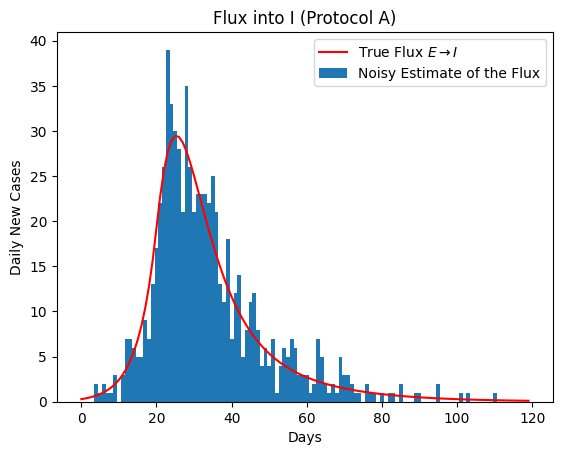

In [10]:
'''Plotting for the flux ->I'''
plt.xlabel('Days')
plt.ylabel('Daily New Cases')
plt.title('Flux into I (Protocol A)')

flux = params[1] * sol[:,1]

plt.plot(flux,color = 'red',label = "True Flux $E \\rightarrow I$")

'''Plotting for the Poisson samples centered at the flux ->I'''


rng = np.random.default_rng(0)

data = rng.poisson(flux)

plt.xlabel('Days')
plt.ylabel('Daily New Cases')
plt.title('Flux into I (Protocol A)')
plt.bar(x=np.arange(0,np.shape(flux)[0]),height = data,width=1,label = "Noisy Estimate of the Flux")
plt.legend()
plt.show()

In [13]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
print("date and time =", dt_string)

now = 2024-09-12 12:40:11.184049
date and time = 12_09_2024_12:40:11


In [14]:
pd.DataFrame(np.expand_dims(data,0)).to_csv(f'../data_sets/calvetti_data_{dt_string}.csv',index = False)
pd.DataFrame(sol).to_csv(f'../data_sets/calvetti_state_{dt_string}.csv',index = False)